In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from sklearn.metrics import *
import ast
import numpy as np

LABELS = ['emp', 'bos', 'caae', 'caca', 'can', 'capi', 'cer', 'dam', 'equ', 'fel', 'fsi', 'gen', 'her', 'lep', 'lut', 'lyn', 'mafo', 'mel', 'mus', 'ory', 'ovar', 'ovor', 'rara', 'sus', 'vul']

In [2]:
# Import a model's values and do sklearn metrics.
def read_values(file_path):
    true_values = []
    pred_values = []
    iou_values = []

    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('True vals:'):
                true_values = ast.literal_eval(line.split(':')[1].strip())
            elif line.startswith('Pred vals:'):
                pred_values = ast.literal_eval(line.split(':')[1].strip())
            elif line.startswith('IoU vals:'):
                iou_values = ast.literal_eval(line.split(':')[1].strip())

    return true_values, pred_values, iou_values

def calculate_mAP(true, pred, iou, iou_threshold=0.5):
    true_positives = defaultdict(int)
    false_positives = defaultdict(int)
    false_negatives = defaultdict(int)
    
    idx = 0
    for t, p in zip(true, pred):
        if t != -1 and p != -1:
            i = iou[idx]
            if i >= iou_threshold:
                true_positives[p] += 1
            else:
                false_positives[p] += 1
                false_negatives[t] += 1
            idx += 1

    APs = {}
    for clas in set(true + pred):
        tp = true_positives[clas]
        fp = false_positives[clas]
    
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        APs[clas] = precision

    mAP = np.mean(list(APs.values()))
    return mAP, APs

def parse_results(model):
    true, pred, iou = read_values(f"{model}_values.txt")
    results = {
        "precision": precision_score(true, pred, average='weighted', zero_division=0),
        "recall": recall_score(true, pred, average='weighted', zero_division=0),
        "f1": f1_score(true, pred, average='weighted', zero_division=0),
        "accuracy": accuracy_score(true, pred),
        "iou": sum(iou) / len(iou) if len(iou) > 0 else 0,
        "matrix": confusion_matrix(true, pred),
        "report": classification_report(true, pred, target_names=LABELS, zero_division=0, output_dict=True),
        "mAP": defaultdict(dict),
    }

    for i in range(50, 100, 5):
        f = i/100
        mAP, APs = calculate_mAP(true, pred, iou, iou_threshold=f)
        results["mAP"][f] = (float(mAP), APs)
    return results

models = {
    "YOLO": parse_results("yolo"),
    "FasterRCNN": parse_results("fasterrcnn"),
    "Megadetector": parse_results("megadetector")
}

COLORS = {
    "YOLO": "#539045",
    "FasterRCNN": "#44739d",
    "Megadetector": "#d48640"
}

In [3]:
results = pd.DataFrame({
    "model": [],
    "precision": [],
    "recall": [],
    "f1": [],
    "iou": [],
    "accuracy": []
})

for model in models.keys():
    results = pd.concat([results, pd.DataFrame({
        "model": [model],
        "precision": [models[model]["precision"]],
        "recall": [models[model]["recall"]],
        "f1": [models[model]["f1"]],
        "iou": [models[model]["iou"]],
        "accuracy": [models[model]["accuracy"]]
    })], ignore_index=True)

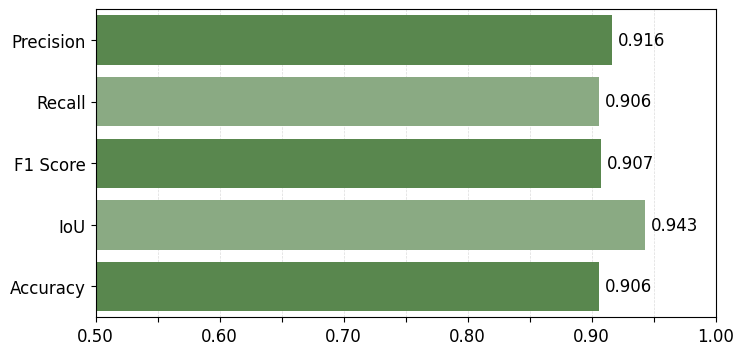

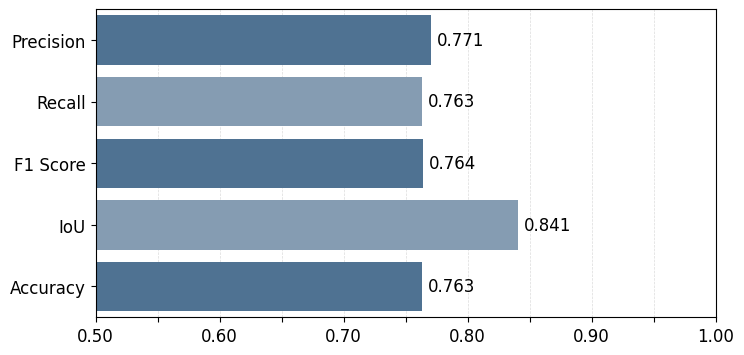

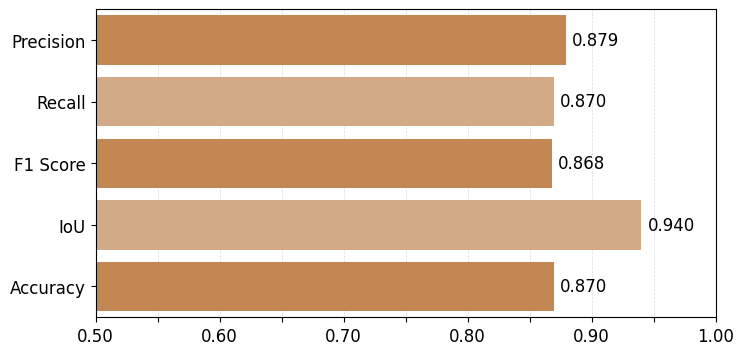

In [37]:
def get_model_plot(table, model):
    metrics = ["precision", "recall", "f1", "iou", "accuracy"]
    names = ["Precision", "Recall", "F1 Score", "IoU", "Accuracy"]
    
    table["metric"] = pd.Categorical(table["metric"], categories=metrics, ordered=True)
    table = table.sort_values(by="metric")
    table["metric"] = table["metric"].map(dict(zip(metrics, names)))
    
    plt.figure(figsize=(8, 4))
    cmap = (sns.light_palette(COLORS[model], as_cmap=False, n_colors=4)[-2:]*3)[1:]
    ax = sns.barplot(x="value", y="metric", data=table, hue="metric", dodge=False, palette=cmap)
    
    for bar in ax.patches:
        plt.text(
            bar.get_width() + 0.005,
            bar.get_y() + bar.get_height() / 2,
            f"{bar.get_width():.3f}",
            va="center",
            ha="left",
            fontsize=12,
        )
    
    xticks = np.linspace(0.5, 1, num=11)
    plt.xticks(ticks=xticks, labels=[f"{tick:.2f}" if i % 2 == 0 else "" for i, tick in enumerate(xticks)], fontsize=12)

    for tick in ax.get_xticks():
        ax.axvline(x=tick, color='lightgray', linestyle='--', linewidth=0.5, alpha=0.8, zorder=0)
    
    plt.xlim(0.5, 1)
    plt.xlabel("")
    plt.yticks(fontsize=12)
    plt.ylabel("")
    plt.savefig(f"images/{model.lower()}_metrics.png", dpi=300, bbox_inches="tight")
    plt.show()

model_tables = {
    model: results[results["model"] == model]
    .melt(id_vars=["model"], var_name="metric", value_name="value")
    .drop(columns="model")
    for model in results["model"].unique()
}

for model, table in model_tables.items():
    get_model_plot(table, model)

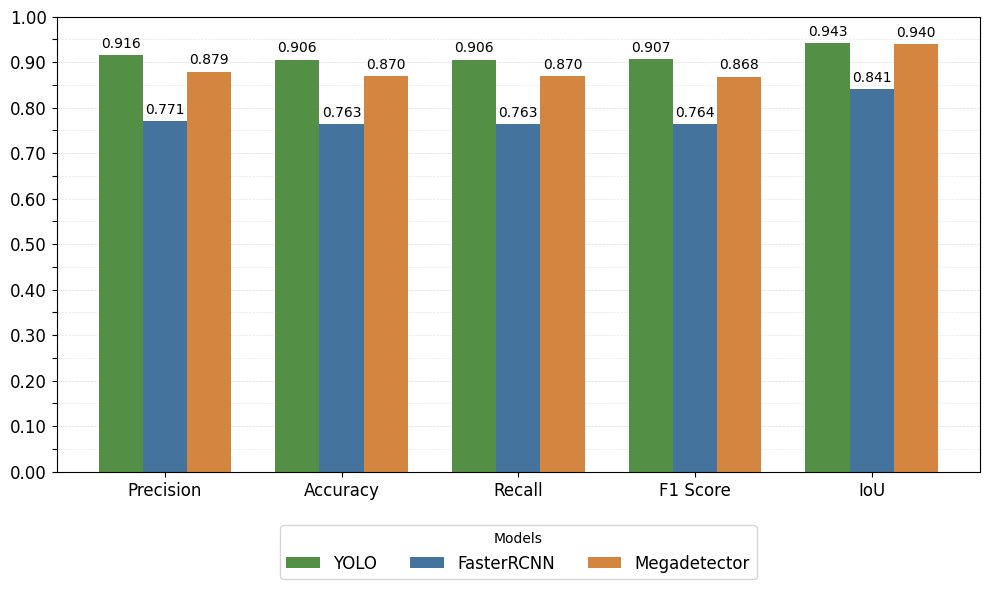

In [38]:
# Plot to compare all model's metrics
def plot_all_metrics(results, colors):
    metrics = ["precision", "accuracy", "recall", "f1", "iou"]
    names = ["Precision", "Accuracy", "Recall", "F1 Score", "IoU"]
    x = np.arange(len(metrics))
    width = 0.25

    _, ax = plt.subplots(figsize=(10, 6))

    for i, model in enumerate(results["model"]):
        values = results.loc[results["model"] == model, metrics].values.flatten()
        ax.bar(x + i * width, values, width, label=model, color=colors[model])

    ax.set_xlabel("")
    ax.set_ylabel("")
    
    ax.set_xticks(x + width)
    ax.set_xticklabels(names, fontsize=12)
    ax.set_ylim(0, 1)
    ax.set_yticks([i * 0.05 for i in range(21)])
    ax.set_yticklabels([f"{i * 0.05:.2f}" if i % 2 == 0 else "" for i in range(21)], fontsize=12)
    for tick in plt.yticks()[0]:
        if tick*100 % 2: plt.axhline(y=tick, color='lightgray', linestyle='--', linewidth=0.5, alpha=0.5, zorder=0)
        else: plt.axhline(y=tick, color='lightgray', linestyle='--', linewidth=0.5, alpha=0.8, zorder=0)

    ax.legend(title="Models", loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=len(results["model"].unique()), fontsize=12)

    for bar in ax.patches:
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.01,
            f"{bar.get_height():.3f}",
            ha="center",
            va="bottom",
            fontsize=10,
        )
    plt.tight_layout()
    plt.savefig('images/metrics_across_models.png', bbox_inches='tight', dpi=300)
    plt.show()

plot_all_metrics(results, COLORS)

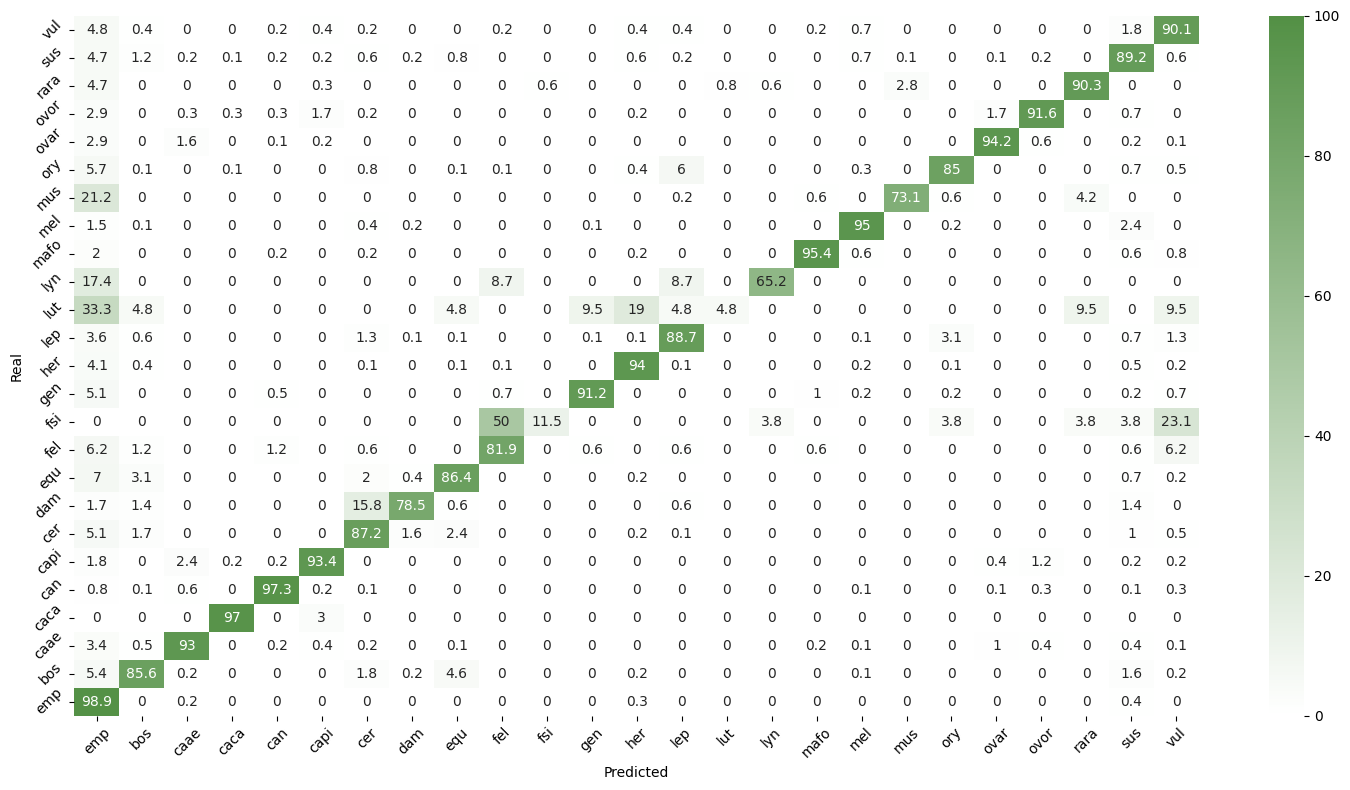

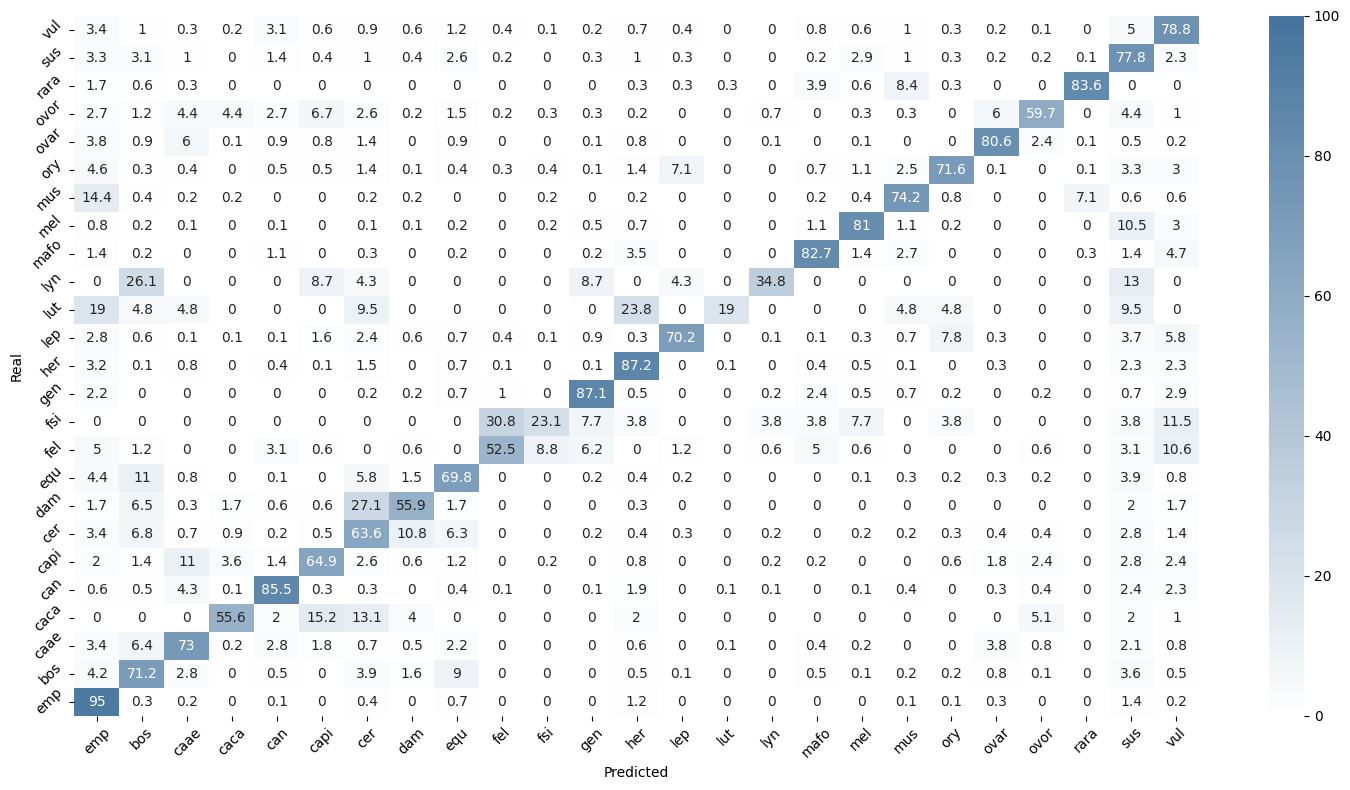

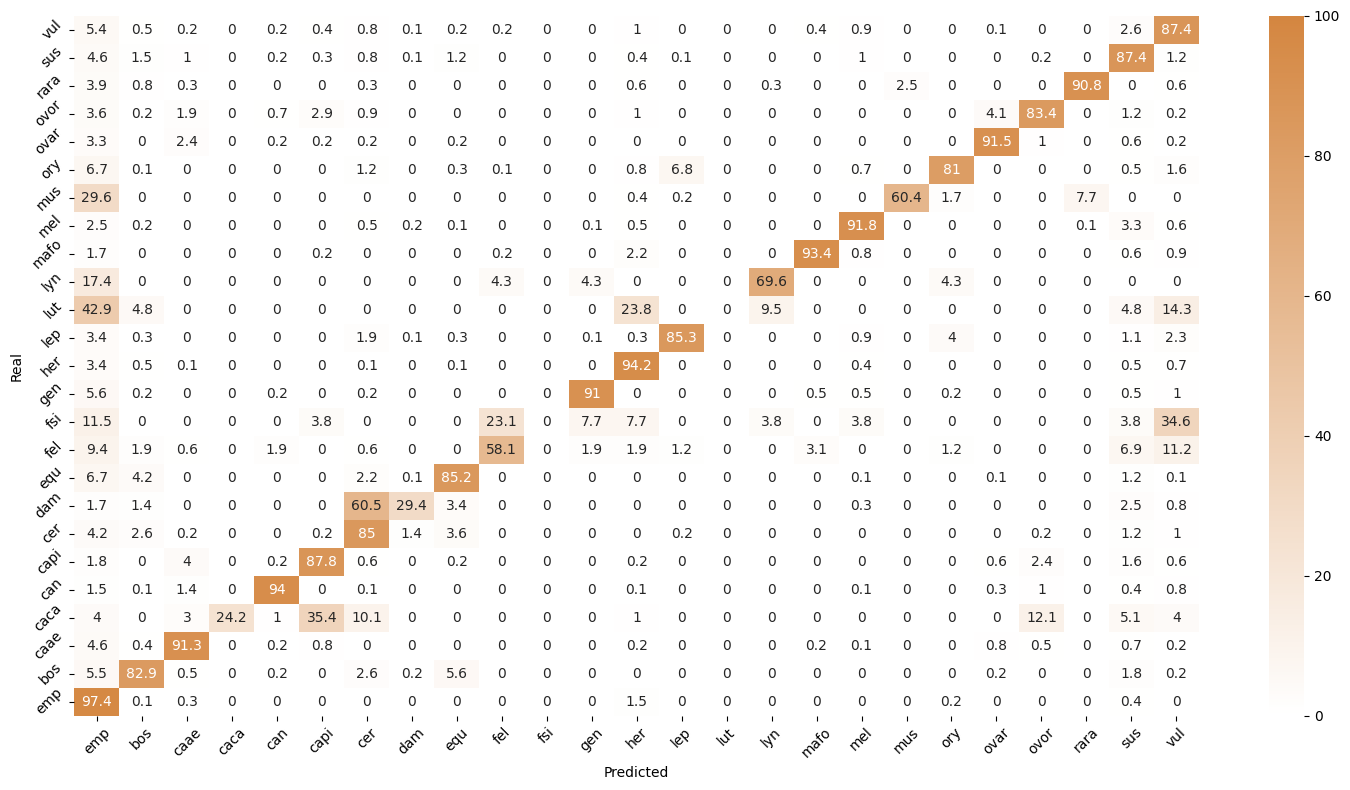

In [39]:
# Normalized confusion matrix
def plot_confusion_matrix(matrix, model):
    matrix = round(matrix.div(matrix.sum(axis=1), axis=0).iloc[::-1] * 100, 1)
    plt.figure(figsize=(15, 8))
    cmap = sns.blend_palette(["white", COLORS[model]], as_cmap=True)
    sns.heatmap(matrix, annot=True, fmt='g', vmin=0, vmax=100, cmap=cmap)
    step_values = [i for i in range(len(LABELS))]
    plt.xticks(ticks=[i + 0.5 for i in step_values], labels=LABELS, rotation=45)
    plt.yticks(ticks=[i + 0.5 for i in step_values[::-1]], labels=LABELS, rotation=45)
    plt.xlabel("Predicted")
    plt.ylabel("Real")
    plt.tight_layout()
    plt.savefig(f"images/matrix_{model.lower()}.png", dpi=300, bbox_inches="tight")
    plt.show()

for model in models.keys():
    matrix = pd.DataFrame(models[model]["matrix"])
    plot_confusion_matrix(matrix, model)

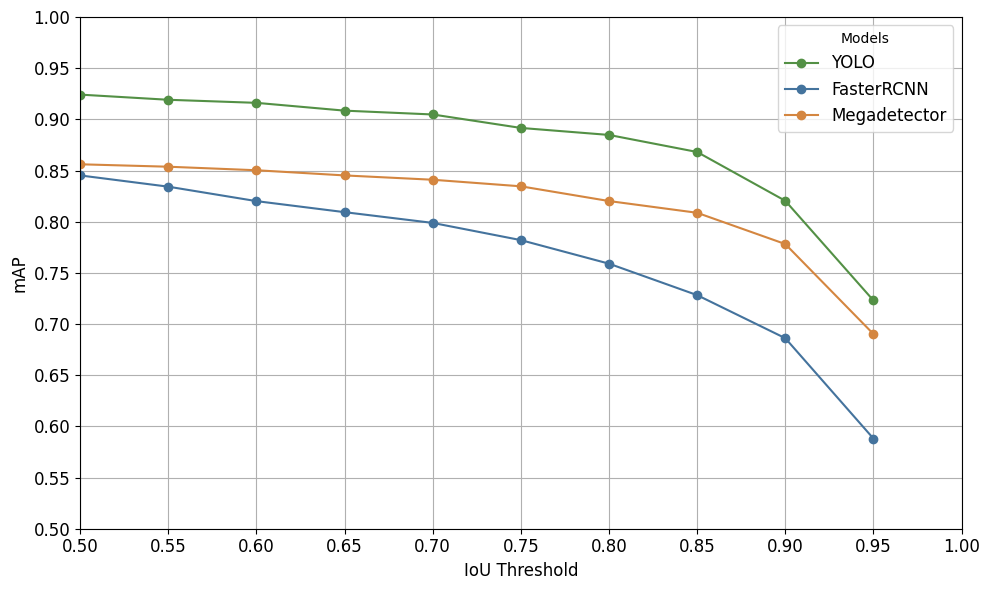

In [40]:
# Plot of mAP vs IoU Threshold curves of all models
def plot_all_mAP_vs_iou(models, colors):
    plt.figure(figsize=(10, 6))
    
    for model, data in models.items():
        mAP = data["mAP"]
        x = list(mAP.keys())
        y = [mAP[i][0] for i in x]
        plt.plot(x, y, marker='o', label=model, color=colors[model])
    
    plt.xticks(ticks=[i * 0.05 for i in range(21)], labels=[f"{i * 0.05:.2f}" for i in range(21)], fontsize=12)
    plt.xlim(0.5, 1)
    plt.yticks(ticks=[i * 0.05 for i in range(21)], labels=[f"{i * 0.05:.2f}" for i in range(21)], fontsize=12)
    plt.ylim(0.5, 1)
    plt.xlabel("IoU Threshold", fontsize=12)
    plt.ylabel("mAP", fontsize=12)
    
    plt.grid()
    plt.legend(title="Models", fontsize=12)
    plt.tight_layout()
    plt.savefig('images/map_across_models.png', dpi=300, bbox_inches="tight")
    plt.show()

plot_all_mAP_vs_iou(models, COLORS)

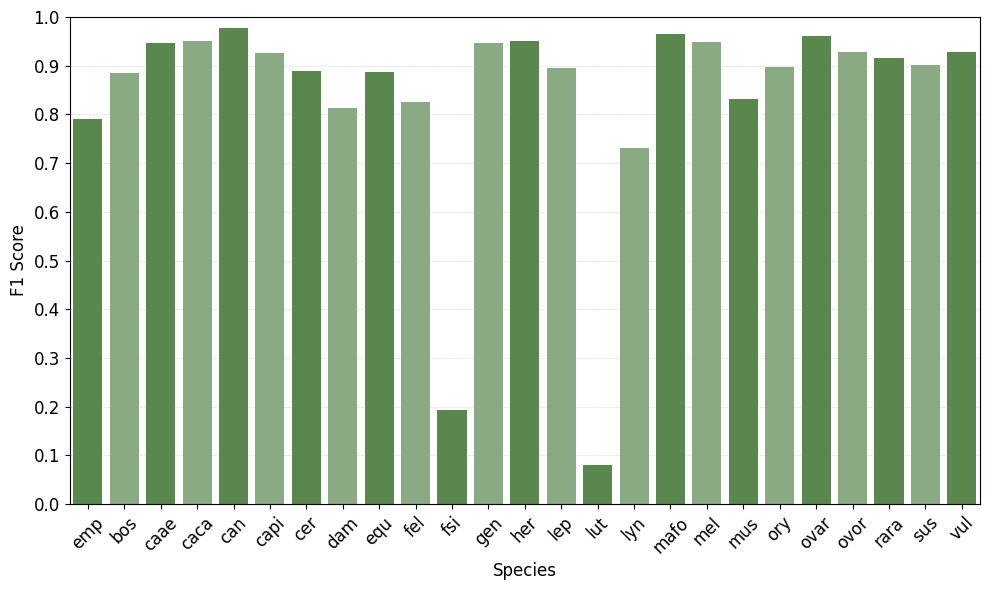

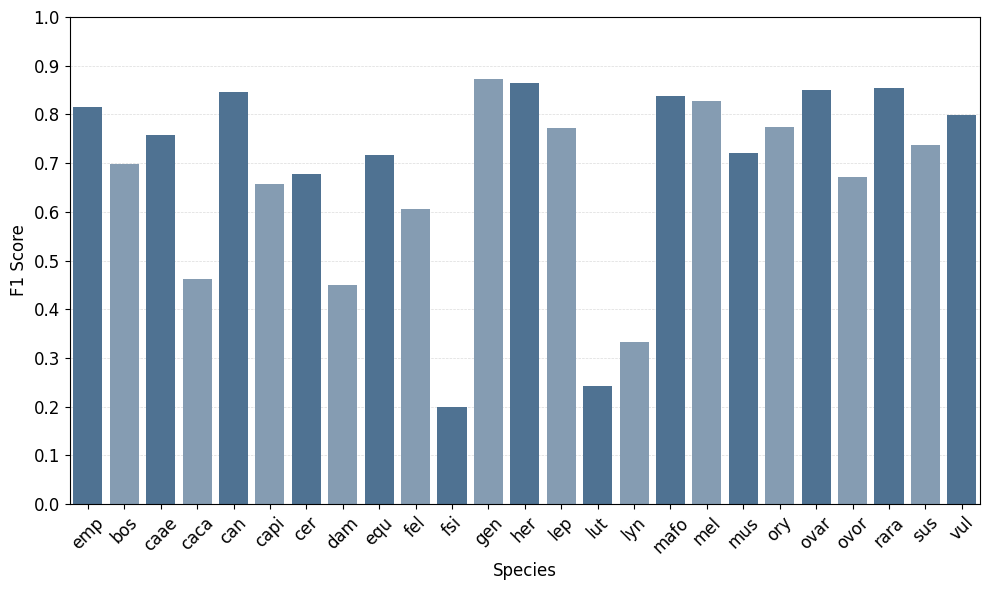

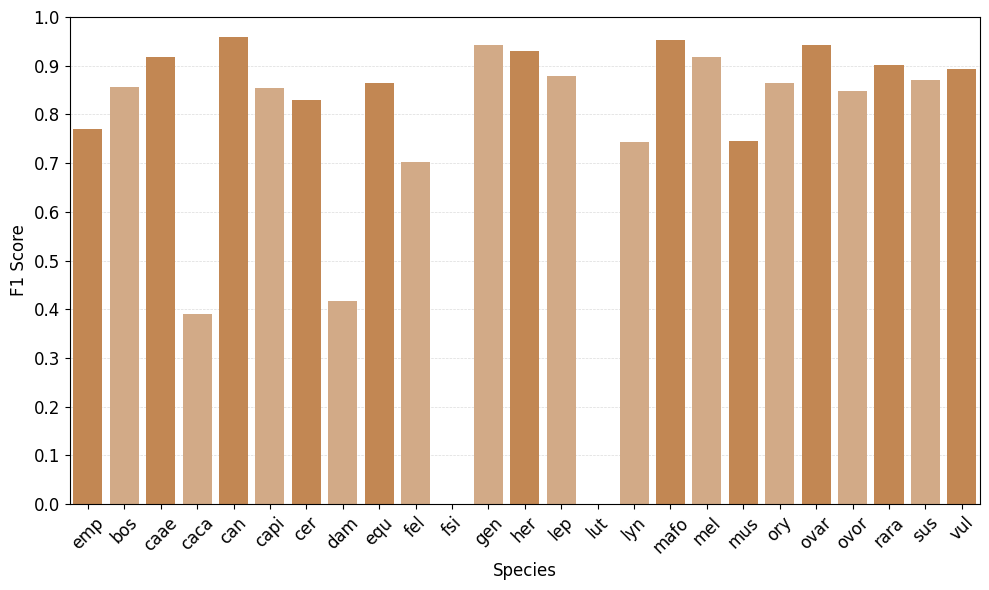

In [41]:
# Barplot of the f1 score for each species
def plot_f1_scores(report, model):
    f1_scores = [report[label]['f1-score'] for label in LABELS]
    labels = LABELS
    
    plt.figure(figsize=(10, 6))
    cmap = (sns.light_palette(COLORS[model], as_cmap=False, n_colors=4)[-2:]*13)[1:]
    sns.barplot(y=f1_scores, x=labels, hue=labels, palette=cmap, dodge=False)
    plt.yticks(ticks=[i * 0.1 for i in range(11)], fontsize=12)
    for tick in plt.yticks()[0]:
        plt.axhline(y=tick, color='lightgray', linestyle='--', linewidth=0.5, alpha=0.8, zorder=0)
    plt.ylabel("F1 Score", fontsize=12)
    plt.ylim(0, 1)

    plt.xlabel("Species", fontsize=12)
    plt.xticks(rotation=45, fontsize=12)

    plt.tight_layout()
    plt.savefig(f"images/f1_{model.lower()}.png", dpi=300, bbox_inches="tight")
    plt.show()

for model in models.keys():
    plot_f1_scores(models[model]['report'], model)